In this notebook, We demonstrate the vanishing gradient problem in Vanilla RNNs. We then try to solve the same task using LSTMs and see how they can overcome this problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

The dataset is a sequence with T timesteps Each timestep consists of 2 numbers: (x0 , x1 )
x0 is a random number, and x1 is either 0 or 1. The goal at the end is to compute the sum of all x0 where
x1 is equal to one, such that at timestep t, if x1 is 1, the network should add x0 to the sum

In [2]:
def generate_data(seq_len, n_samples, n_summands):
    x = np.zeros((seq_len, n_samples, 2), dtype=np.float32)
    y = np.zeros((n_samples, 1), dtype=np.float32)
    x[:, :, 0] = np.random.uniform(-1, 1, size=(seq_len, n_samples))
    for i in range(n_samples):
        idx = np.random.choice(seq_len, size=n_summands, replace=False)
        x[idx, i, 1] = 1
        y[i] = x[idx, i, 0].sum()
    return x, y

In [3]:
def forward_pass(x, w, r, b, wo, bo):
    '''
    Calculate the output of a recurrent neural network with tanh activation
    and a linear layer on top
    Params:
        x: input matrix [n_timesteps * n_samples * 2]
        w: non-recurrent weights
        r: recurrent weights
        b: biases
        wo: output-layer weights
        bo: output-layer biases

    Returns:
        h: matrix of activations (n_timesteps, n_samples, n_hiddens)
        o: final predictions
    '''
    t_max, n, _ = x.shape
    h = np.empty([t_max, n, w.shape[0]], dtype=np.float32) # storage for the hidden activations
    for t in range(t_max):
        z = np.dot(x[t], w.T) + b
        if t > 0:
            z += np.dot(h[t-1], r.T)
        h[t] = np.tanh(z)
    o = np.dot(h[-1], wo.T) + bo
    return h, o


In [4]:
def backward_pass(x, h, w, b, r, wo, bo, o, y):
    t_max, n, _ = x.shape
    dw = np.zeros_like(w)
    db = np.zeros_like(b)
    dr = np.zeros_like(r)
    dwo = 0
    dbo = 0
    
    delta_o=o-y
    dwo=np.dot(delta_o.T,h[-1])
     
    dbo=delta_o.sum(0)
      
    delta_t=np.dot(delta_o,wo)*(1-h[-1]**2)
    
    for t in range(t_max-1,-1,-1):
        
        
        if t>0:
            
            dr+=np.dot(delta_t.T,h[t-1])
        
        dw+=np.dot(delta_t.T,x[t])
        
        db+=delta_t.sum(0)
        
        delta_t=np.dot(delta_t,r)*(1-h[t-1]**2)

    return dw, dr, db, dwo, dbo


In [5]:
def SGD(lr,w,r,b,wo,bo,dw, dr, db, dwo, dbo):
    
    w-=lr*dw
    
    r-=lr*dr
    
    b-=lr*db
    
    wo-=lr*dwo
    
    bo-=lr*dbo
    
    return w,r,b,wo,bo

In [6]:
def initialize_weights(n_hidden):
    
    np.random.seed(500)
    
    w = np.random.normal(size=(n_hidden, 2), scale=0.1).astype(np.float64)
    r = np.random.normal(size=(n_hidden, n_hidden), scale=0.1).astype(np.float64)
    b = np.zeros(n_hidden, dtype=np.float64)
    wo = np.random.normal(size=(1, n_hidden), scale=0.01).astype(np.float64)
    bo = np.zeros(1, dtype=np.float64)
    
    return w,r,b,wo,bo

In [7]:
def squared_loss(o,y):
    
    loss = 0.5*np.sum(np.square(o-y))
    
    return loss

In [14]:
def train_RNN(x,y,lr,n_hidden,epochs):
    
    loss=np.zeros(epochs)
    rmse=np.zeros(epochs)
    
    w,r,b,wo,bo=initialize_weights(n_hidden)
    
    for i in range(epochs):
        
    
        h,o=forward_pass(x, w, r, b, wo, bo)
    
        loss[i]=squared_loss(o,y)
        
        rmse[i]=np.sqrt(loss[i]/y.shape[0])
        
        dw, dr, db, dwo, dbo=backward_pass(x, h, w, b, r, wo, bo, o, y)
        
        w,r,b,wo,bo=SGD(lr,w,r,b,wo,bo,dw, dr, db, dwo, dbo)
        
        if i%100==0:
        
            print("Epoch",i+1)
            print("Training loss",loss[i])
            print("RMSE",rmse[i])
            print("#######################")
        
    return loss,rmse,w,r,b,wo,bo

In [11]:
# Code for gradient checking


def loss(w, r, b, wo, bo, x, y):
    _, o = forward_pass(x, w, r, b, wo, bo)
    err = 0.5*np.sum(np.square(o-y))
    return err


n_samples = 100
n_timesteps = 3
n_summands = 1
n_hidden = 4

x, y = generate_data(n_timesteps, n_samples, n_summands)
x = x.astype(np.float64)
y = y.astype(np.float64)
x *= 64
w = np.random.normal(size=(n_hidden, 2), scale=0.1).astype(np.float64)
r = np.random.normal(size=(n_hidden, n_hidden), scale=0.1).astype(np.float64)
b = np.zeros(n_hidden, dtype=np.float64)
wo = np.random.normal(size=(1, n_hidden), scale=0.01).astype(np.float64)
bo = np.zeros(1, dtype=np.float64)


from scipy.optimize import approx_fprime

eta = 1e-5
nwo = approx_fprime(wo.ravel(), lambda wo0 : loss(w, r, b, wo0.reshape(wo.shape), bo, x, y), eta)
nbo = approx_fprime(bo.ravel(), lambda bo0 : loss(w, r, b, wo, bo0.reshape(bo.shape), x, y), eta)
nw = approx_fprime(w.ravel(), lambda w0 : loss(w0.reshape(w.shape), r, b, wo, bo, x, y), eta)
nr = approx_fprime(r.ravel(), lambda r0 : loss(w, r0.reshape(r.shape), b, wo, bo, x, y), eta)
nb = approx_fprime(b.ravel(), lambda b0 : loss(w, r, b0.reshape(b.shape), wo, bo, x, y), eta)

nwo = nwo.reshape(wo.shape)
nbo = nbo.reshape(bo.shape)
nw = nw.reshape(w.shape)
nr = nr.reshape(r.shape)
nb = nb.reshape(b.shape)

h, o = forward_pass(x, w, r, b, wo, bo)

dw, dr, db, dwo, dbo = backward_pass(x, h, w, b, r, wo, bo, o, y)

print("Max. deviation dwo:", np.abs(nwo-dwo).max())
print("Max. deviation dbo:", np.abs(nbo-dbo).max())
print("Max. deviation db: ", np.abs(nb-db).max())
print("Max. deviation dw: ", np.abs(nw-dw).max())
print("Max. deviation dr: ", np.abs(nr-dr).max())


Max. deviation dwo: 0.00044646058905151165
Max. deviation dbo: 0.0004999996521348749
Max. deviation db:  0.00010935805119172831
Max. deviation dw:  0.0003556318148585369
Max. deviation dr:  0.00022936828096618324


**8 Timesteps**

We first train our Vanilla RNN on a sequence with 8 timesteps and view the training performance

In [12]:
data,target=generate_data(8,1000,3) #8 timesteps
print("max",np.max(target))
print("min",np.min(target))
print("range",np.max(target)-np.min(target))

max 2.7334197
min -2.675731
range 5.4091506


Epoch 1
Training loss 483.0883738253315
RMSE 0.6950455911847305
#######################
Epoch 101
Training loss 462.2733943942172
RMSE 0.679906901269738
#######################
Epoch 201
Training loss 324.59200506907666
RMSE 0.5697297649492052
#######################
Epoch 301
Training loss 335.34716150565504
RMSE 0.5790916693457565
#######################
Epoch 401
Training loss 333.89424721500166
RMSE 0.5778358306777122
#######################
Epoch 501
Training loss 332.85443182840646
RMSE 0.5769353792483232
#######################
Epoch 601
Training loss 331.7139405137518
RMSE 0.5759461263987733
#######################
Epoch 701
Training loss 330.21998308232037
RMSE 0.5746477034517065
#######################
Epoch 801
Training loss 327.61528434808747
RMSE 0.5723768726530515
#######################
Epoch 901
Training loss 320.18349573426315
RMSE 0.565847590552671
#######################
Epoch 1001
Training loss 293.75824607079966
RMSE 0.5419946919212398
#######################
Epoch

Epoch 9101
Training loss 44.1037685520635
RMSE 0.21000897255132578
#######################
Epoch 9201
Training loss 43.952842478359116
RMSE 0.20964933216769166
#######################
Epoch 9301
Training loss 43.80240479826
RMSE 0.20929024057098317
#######################
Epoch 9401
Training loss 43.65194356476729
RMSE 0.20893047543325816
#######################
Epoch 9501
Training loss 43.500886941719486
RMSE 0.20856866241532904
#######################
Epoch 9601
Training loss 43.34865745168682
RMSE 0.20820340403482077
#######################
Epoch 9701
Training loss 43.19456101259361
RMSE 0.20783301232622697
#######################
Epoch 9801
Training loss 43.03784616472355
RMSE 0.20745564866911564
#######################
Epoch 9901
Training loss 42.87758920024369
RMSE 0.2070690445243897
#######################


Text(0,0.5,'Loss')

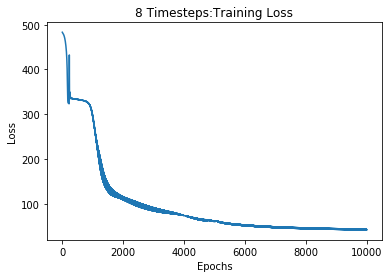

In [15]:
n_hidden=4
lr=10**-4
epochs=10000

loss,rmse,w,r,b,wo,bo=train_RNN(data,target,lr,n_hidden,epochs)

plt.plot(loss)
plt.title("8 Timesteps:Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

It is clear from the above that the network manages to converge at the end a learn to mimic the original output.

**64 Timesteps**

Next, we try to train our RNN on a sequence with 64 timesteps

In [16]:
data,target=generate_data(64,1000,3) #64 timesteps
print("max",np.max(target))
print("min",np.min(target))
print("range",np.max(target)-np.min(target))

max 2.5305557
min -2.5284603
range 5.059016


Epoch 1
Training loss 521.6005081509234
RMSE 0.7222191552090843
#######################
Epoch 101
Training loss 520.7785682793206
RMSE 0.7216498931471691
#######################
Epoch 201
Training loss 520.7628519180189
RMSE 0.7216390038779908
#######################
Epoch 301
Training loss 520.7470252410442
RMSE 0.7216280380092255
#######################
Epoch 401
Training loss 520.7305247701652
RMSE 0.7216166051097807
#######################
Epoch 501
Training loss 520.712904619309
RMSE 0.7216043962028703
#######################
Epoch 601
Training loss 520.6938074839463
RMSE 0.7215911636681441
#######################
Epoch 701
Training loss 520.6729510904931
RMSE 0.7215767118543206
#######################
Epoch 801
Training loss 520.6501210806535
RMSE 0.7215608921502423
#######################
Epoch 901
Training loss 520.6251634395735
RMSE 0.7215435977399935
#######################
Epoch 1001
Training loss 520.5979713601366
RMSE 0.721524754502669
#######################
Epoch 1101
Tr

Epoch 9101
Training loss 518.687420386816
RMSE 0.7201995698324292
#######################
Epoch 9201
Training loss 518.6083865433709
RMSE 0.7201446983373347
#######################
Epoch 9301
Training loss 518.5101227511971
RMSE 0.7200764700718925
#######################
Epoch 9401
Training loss 518.4074163058422
RMSE 0.7200051501939706
#######################
Epoch 9501
Training loss 518.3012869985153
RMSE 0.7199314460408819
#######################
Epoch 9601
Training loss 518.1908968307962
RMSE 0.7198547748197522
#######################
Epoch 9701
Training loss 518.0186677374044
RMSE 0.7197351372118804
#######################
Epoch 9801
Training loss 517.9071489745188
RMSE 0.7196576609572908
#######################
Epoch 9901
Training loss 517.7598675489484
RMSE 0.7195553262598703
#######################


Text(0,0.5,'Loss')

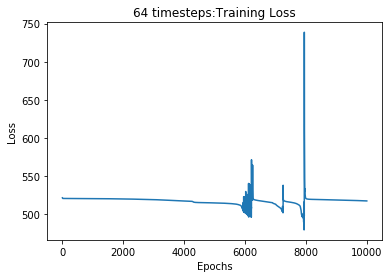

In [17]:
n_hidden=4
lr=10**-4
epochs=10000

loss,rmse,w,r,b,wo,bo=train_RNN(data,target,lr,n_hidden,epochs)

plt.plot(loss)
plt.title("64 timesteps:Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

It can be seen from the above that even after sufficiently many epochs the network doesn't converge due to the vanishing gradient problem with vanilla RNNs.

## LSTM

Now, we construct a LSTM and try to solve the same task for 8 and 64 timesteps

In [5]:
dtype = torch.float

In [49]:
def initialize_weights(x,n_hidden):
    
    z_size=n_hidden+x.shape[2]
    
    wf=torch.tensor((torch.randn(n_hidden,z_size)*0.1),dtype=dtype,requires_grad=True)
    bf=torch.ones(n_hidden,dtype=dtype,requires_grad=True)
    
    wi=torch.tensor((torch.randn(n_hidden,z_size)*0.1),dtype=dtype,requires_grad=True)
    bi=torch.zeros(n_hidden,dtype=dtype,requires_grad=True)
    
    wc=torch.tensor((torch.randn(n_hidden,z_size)*0.1),dtype=dtype,requires_grad=True)
    bc=torch.zeros(n_hidden,dtype=dtype,requires_grad=True)
    
    wo=torch.tensor((torch.randn(n_hidden,z_size)*0.1),dtype=dtype,requires_grad=True)
    bo=torch.zeros(n_hidden,dtype=dtype,requires_grad=True)
    
    w=torch.tensor((torch.randn(1,n_hidden)*0.1),dtype=dtype,requires_grad=True)
    b=torch.zeros(1,dtype=dtype,requires_grad=True)
    
    return wf,bf,wi,bi,wc,bc,wo,bo,w,b

In [36]:
def forward_pass(x, wf,bf,wi,bi,wc,bc,wo,bo,w,b,n_hidden):
    
    t_max, n, _ = x.shape
    
    h = torch.zeros(t_max, n,n_hidden, dtype=dtype)
    
    c_prev=torch.zeros(n,n_hidden,dtype=dtype)
    
    for t in range(t_max):
        
        if t==0:
            
            z=torch.cat((x[0],h[0]),1)
        
        else:
            
            z=torch.cat((x[t],h[t-1]),1)
        
        
        
        f=F.sigmoid(z.mm(wf.transpose(0,1))+bf)
        
        i=F.sigmoid(z.mm(wi.transpose(0,1))+bi)
        
        c_tilda=F.tanh(z.mm(wc.transpose(0,1))+bc)
        
        c=f*c_prev + i*c_tilda
        
        o=F.sigmoid(z.mm(wo.transpose(0,1))+bo)
        
        h[t]=o*F.tanh(c)
        
        c_prev=c
        
    y_pred=h[t_max-1].mm(w.transpose(0,1)) + b  #output linear layer
    
    return y_pred, h[t_max-1]
    
    

In [74]:
def train_LSTM(x,y,n_hidden,learning_rate,epochs):
    
    error=[]
    rmse=[]
    
    wf,bf,wi,bi,wc,bc,wo,bo,w,b=initialize_weights(x,n_hidden)
    
    for i in range(epochs):
        
        y_pred, h =forward_pass(x, wf,bf,wi,bi,wc,bc,wo,bo,w,b,n_hidden)
        
        loss = 0.5* ((y_pred - y).pow(2).mean())
        
        error.append(loss.item())
        
        rmse.append(np.sqrt((error[i]*2)))
        
        loss.backward()
        
        if i % 100 == 0:
            print("Epoch",i+1)
            print("Training loss=", error[i])
            print("RMSE=", rmse[i])
        
            print("##########")

        
        with torch.no_grad():
            wf -= learning_rate * wf.grad
            bf -= learning_rate * bf.grad
                    
            wi -= learning_rate * wi.grad
            bi -= learning_rate * bi.grad
            
            wc -= learning_rate * wc.grad
            bc -= learning_rate * bc.grad
            
            wo -= learning_rate * wo.grad
            bo -= learning_rate * bo.grad
            
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad
            
            

            wf.grad.zero_()
            bf.grad.zero_()
            
            wi.grad.zero_()
            bi.grad.zero_()
            
            wc.grad.zero_()
            bc.grad.zero_()
            
            wo.grad.zero_()
            bo.grad.zero_()
            
            w.grad.zero_()
            b.grad.zero_()
    
    return error

**8 timesteps**

First, we train our LSTM network on a 8 timestep sequence.

In [70]:
data,target=generate_data(8,1000,3) 
X=torch.from_numpy(data)
y=torch.from_numpy(target)

In [71]:
print("max",np.max(target))
print("min",np.min(target))
print("Output range",np.max(target)-np.min(target))

max 2.715331
min -2.777919
Output range 5.49325


Epoch 1
Training loss= 0.5212767720222473
RMSE= 1.0210551131278343
##########
Epoch 101
Training loss= 0.49332624673843384
RMSE= 0.9933038273745187
##########
Epoch 201
Training loss= 0.3370172381401062
RMSE= 0.8209960269576293
##########
Epoch 301
Training loss= 0.28328728675842285
RMSE= 0.7527114809253581
##########
Epoch 401
Training loss= 0.22984181344509125
RMSE= 0.6779997248452115
##########
Epoch 501
Training loss= 0.12694144248962402
RMSE= 0.5038679241420791
##########
Epoch 601
Training loss= 0.07222048193216324
RMSE= 0.3800538959994049
##########
Epoch 701
Training loss= 0.04421555995941162
RMSE= 0.29737370414820347
##########
Epoch 801
Training loss= 0.03271656110882759
RMSE= 0.25579898791366473
##########
Epoch 901
Training loss= 0.027323264628648758
RMSE= 0.23376597112774458
##########
Epoch 1001
Training loss= 0.02410399727523327
RMSE= 0.2195631903358724
##########
Epoch 1101
Training loss= 0.02187495119869709
RMSE= 0.2091647733185351
##########
Epoch 1201
Training loss= 

Epoch 9901
Training loss= 0.0027771226596087217
RMSE= 0.07452680939915142
##########


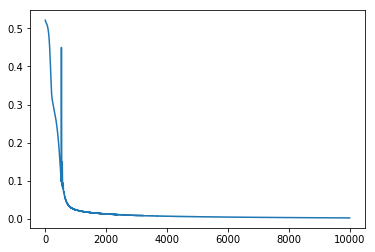

In [72]:
n_hidden=4
lr=1e-1
epochs=10000

train_loss=train_LSTM(X,y,n_hidden,lr,epochs)
plt.plot(train_loss)

Text(0.5,1,'LSTM: 8 timesteps')

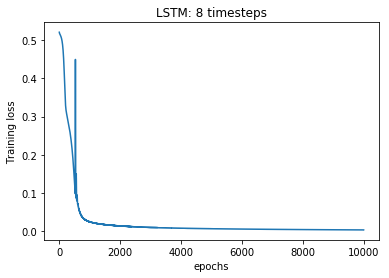

In [73]:
plt.plot(train_loss)
plt.xlabel("epochs")
plt.ylabel("Training loss")
plt.title("LSTM: 8 timesteps")

It can be seen that the network prefectly converges

note that generally we should have a validation set to detect overfitting but here the target is to compare the training performance for Vanilla RNNs and LSTMs.

**64 timsteps**

Next, we train our LSTM network on a 64 timestep sequence and watch whether the network is able to learn the task or not

In [68]:
data,target=generate_data(64,1000,3) 
X=torch.from_numpy(data)
y=torch.from_numpy(target)

In [69]:
print("max",np.max(target))
print("min",np.min(target))
print("Output range",np.max(target)-np.min(target))

max 2.7693927
min -2.5599196
Output range 5.3293123


Epoch 1
Training loss= 0.4968961775302887
RMSE= 0.9968913456643995
##########
Epoch 101
Training loss= 0.4967455267906189
RMSE= 0.9967402136872164
##########
Epoch 201
Training loss= 0.49671536684036255
RMSE= 0.9967099546411309
##########
Epoch 301
Training loss= 0.4966845214366913
RMSE= 0.9966790069392365
##########
Epoch 401
Training loss= 0.4966524541378021
RMSE= 0.9966468322708923
##########
Epoch 501
Training loss= 0.49661871790885925
RMSE= 0.9966129819632686
##########
Epoch 601
Training loss= 0.4965827763080597
RMSE= 0.9965769175613689
##########
Epoch 701
Training loss= 0.49654409289360046
RMSE= 0.9965381005195942
##########
Epoch 801
Training loss= 0.49650198221206665
RMSE= 0.9964958426527094
##########
Epoch 901
Training loss= 0.49645572900772095
RMSE= 0.996449425718858
##########
Epoch 1001
Training loss= 0.49640437960624695
RMSE= 0.9963978920152802
##########
Epoch 1101
Training loss= 0.4963468015193939
RMSE= 0.996340104100396
##########
Epoch 1201
Training loss= 0.49628150

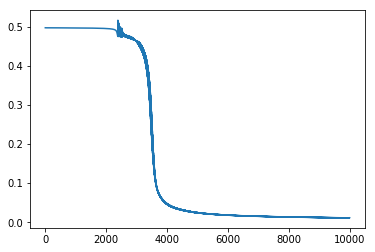

In [60]:
n_hidden=4
lr=1e-1
epochs=10000

train_loss=train_LSTM(X,y,n_hidden,lr,epochs)
plt.plot(train_loss)

Text(0.5,1,'LSTM: 64 timesteps')

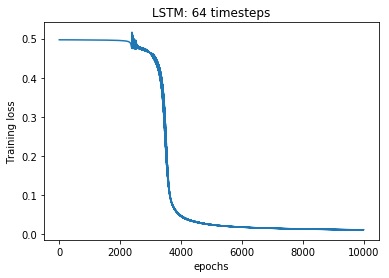

In [61]:
plt.plot(train_loss)
plt.xlabel("epochs")
plt.ylabel("Training loss")
plt.title("LSTM: 64 timesteps")

It is clear from the above plot that for 64 timesteps the task is learnable with LSTMS unlike Vanilla RNNs as they could overcome the vanishing gradient problem.